In [2]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import pandas as pd
from typing import Optional, List, Dict, Tuple
import os
import sys
import pandas as pd
import anndata as ad
from tqdm.notebook import tqdm
import os
from pathlib import Path

# Add the parent directory to the path
sys.path.append(os.path.dirname(os.getcwd()))

# Now import from inference_module
from inference_module import InferenceModule

/home/aadduri/miniconda/envs/pertsets/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
inference_module = InferenceModule(model_folder='/large_storage/ctc/userspace/aadduri/mar5/replogle_scgpt_samp_ctrl/fold4')

adata = sc.read_h5ad('/large_storage/ctc/userspace/aadduri/datasets/hvg/replogle/rpe1.h5')

Loaded perturbation map with 2245 perturbations
Loading model from checkpoint: /large_storage/ctc/userspace/aadduri/mar5/replogle_scgpt_samp_ctrl/fold4/checkpoints/last.ckpt


INFO:models.base:Initialized gene decoder for embedding X_scGPT to gene space


NeuralOTPerturbationModel(
  (loss_fn): SamplesLoss()
  (gene_decoder): LatentToGeneDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (2): GELU(approximate='none')
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=512, out_features=1024, bias=True)
      (5): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (6): GELU(approximate='none')
      (7): Dropout(p=0.1, inplace=False)
      (8): Linear(in_features=1024, out_features=3609, bias=True)
    )
  )
  (pert_encoder): Sequential(
    (0): Linear(in_features=2245, out_features=256, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): GELU(approximate='none')
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): GELU(approximate='

In [ ]:
# 1. Get all unique perturbations and count cells per perturbation
pert_counts = adata.obs['gene'].value_counts()
print(f"Found {len(pert_counts)} unique perturbations")
print(f"Top 5 perturbations by frequency: {pert_counts.head().to_dict()}")

# Control cells to sample from
all_ctrl_cells = adata[adata.obs['gene'] == 'non-targeting'].copy()
print(f"Total control cells available: {all_ctrl_cells.n_obs}")

# 2. Generate predictions for each perturbation
all_predictions = []
np.random.seed(42)  # For reproducibility

# Create progress bar for all perturbations
for perturbation in pert_counts.index:
    # Get number of cells for this perturbation
    n_cells = pert_counts[perturbation]
    
    # Sample this many control cells (with replacement if needed)
    if n_cells <= all_ctrl_cells.n_obs:
        # Sample without replacement if we have enough cells
        sample_indices = np.random.choice(
            np.arange(all_ctrl_cells.n_obs), 
            size=n_cells, 
            replace=False
        )
    else:
        # Sample with replacement if we need more cells than available
        sample_indices = np.random.choice(
            np.arange(all_ctrl_cells.n_obs), 
            size=n_cells, 
            replace=True
        )
    
    ctrl_subset = all_ctrl_cells[sample_indices].copy()
    
    # Set the perturbation
    ctrl_subset.obs['gene'] = perturbation
    
    # Run inference
    try:
        pred_subset = inference_module.perturb(
            ctrl_subset,
            pert_key='gene',
            celltype_key='cell_type'
        )
        
        # Add metadata to track source perturbation
        pred_subset.obs['original_perturbation'] = perturbation
        pred_subset.obs['is_predicted'] = True
        
        # Store this batch of predictions
        all_predictions.append(pred_subset)
        
        print(f"Generated {pred_subset.n_obs} predictions for {perturbation}")
    except Exception as e:
        print(f"Error generating predictions for {perturbation}: {str(e)}")



In [6]:
# 3. Combine all predictions into a single AnnData object
if all_predictions:
    # Concatenate all predictions
    pred_adata = ad.concat(all_predictions, merge="same")
    
    # Make sure we have the same gene set as the original dataset
    if adata.var_names.equals(pred_adata.var_names):
        print("Prediction gene set matches original dataset")
    else:
        print("Warning: prediction gene set differs from original dataset")
    
    print(f"Generated complete prediction dataset with {pred_adata.n_obs} cells")
    print(f"Original dataset has {adata.n_obs} cells")
    
    # 4. Basic comparison statistics
    print("\nPerturbations comparison:")
    pred_pert_counts = pred_adata.obs['original_perturbation'].value_counts()
    comparison_df = pd.DataFrame({
        'Real_cells': pert_counts,
        'Predicted_cells': pred_pert_counts
    }).fillna(0)
    
    # Calculate percentage match
    comparison_df['Cell_count_match'] = comparison_df.apply(
        lambda row: min(row['Real_cells'], row['Predicted_cells']) / max(row['Real_cells'], row['Predicted_cells']) * 100 
        if max(row['Real_cells'], row['Predicted_cells']) > 0 else 0, 
        axis=1
    )
    
    print(comparison_df.sort_values('Real_cells', ascending=False).head(10))
    
    # Output prediction AnnData for downstream analysis
    pred_adata
else:
    print("No predictions were generated successfully")

Prediction gene set matches original dataset
Generated complete prediction dataset with 54915 cells
Original dataset has 54915 cells

Perturbations comparison:
               Real_cells  Predicted_cells  Cell_count_match
non-targeting       11485            11485             100.0
MRPL36               1603             1603             100.0
GFM1                 1496             1496             100.0
MRPL35               1427             1427             100.0
SMG5                  430              430             100.0
SMN2                  374              374             100.0
SPC25                 322              322             100.0
EIF3CL                304              304             100.0
TIMM23B               298              298             100.0
MRPL38                258              258             100.0


... storing 'source' as categorical
... storing 'perturbation' as categorical


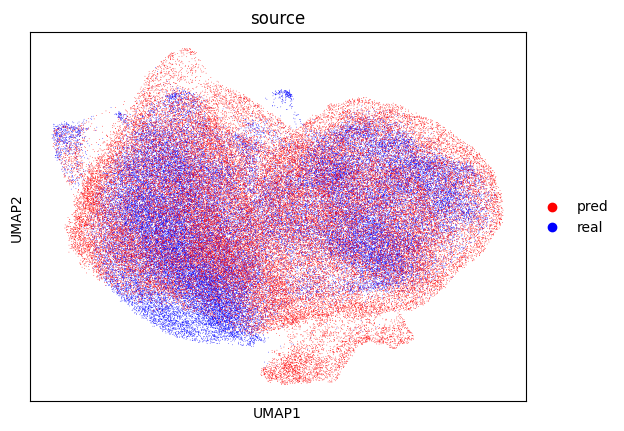

In [7]:
real_embeddings = adata.obsm['X_scGPT']
pred_embeddings = pred_adata.obsm['X_scGPT_pert']

# Combine them
combined_embeddings = np.vstack([real_embeddings, pred_embeddings])
sources = ['real'] * adata.n_obs + ['pred'] * pred_adata.n_obs

# Create an integrated AnnData for visualization
integrated = ad.AnnData(X=combined_embeddings)
integrated.obs['source'] = sources
integrated.obs['perturbation'] = list(adata.obs['gene']) + list(pred_adata.obs['original_perturbation'])

sc.pp.pca(integrated)
sc.pp.neighbors(integrated, use_rep='X_pca')
sc.tl.umap(integrated)
sc.pl.umap(integrated, color='source', palette={'real': 'blue', 'pred': 'red'})
